In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

In [85]:

def z_0(w0, lam0, n=1):
   return np.pi*(w0**2)*n*(1/lam0)


def spot_size(z, w0, lam0):
   z0 = z_0(w0, lam0)
  
   return ((w0**2)*(1+(z/z0)**2))**0.5




def radius(z, w0, lam0):
   z0 = z_0(w0,lam0)
  
   return z*(1+(z0/z)**2)
  
  
def Gaussian(r, z, w0, lam0, n=1):
   k = (2*np.pi)/lam0
  
   z0 = z_0(w0,lam0)
  
   w = spot_size(z,w0,lam0)
  
   R = radius(z,w0,lam0)
  
   amp = (w0/w)*np.exp(-1*(r**2/w**2))
  
   long_phase =  np.exp(1j* ((-k*z)- (np.arctan(z/z0))))
  
   radial_phase = np.exp(1j* (-1*(k*r**2)/(2*R)))
  


   return amp*long_phase*radial_phase, w






def q_factor_wz(z, w0, lam0, n=1):
  
   s = spot_size(z,w0,lam0)
   r = radius(z,w0,lam0)


   q = ((1/r) - 1j*(lam0/(np.pi*n*(s**2))))**-1
  
   return q


def q_factor_sr(s,r,lam0, n=1):
  
  
   q = ((1/r) - 1j*(lam0/(np.pi*n*(s**2))))**-1
  
   return q
  
  
def q_final(qIn, M):
  
   A = M[0,0]
   B = M[0,1]
   C = M[1,0]
   D = M[1,1]
  
  
  
   return ((A*qIn)+B)/((C*qIn)+D)
  
def q_solve(q, lam0, n=1):
  
   A = q.real
   B = q.imag
  
   z = A
   w0 = ((B*lam0)/(np.pi * n))**0.5
  
   return z, w0
  
def lens_matrix(f, n=1):
  
   A = 1
   B = 0
   C = (-1)/f
   D = 1
  
   return np.matrix([[A,B],[C,D]])


def free_space_matrix(L, n=1):
  
   A = 1
   B = L/n
   C = 0
   D = 1
  
   return np.matrix([[A,B],[C,D]])



In [86]:
#d0: distance from laser to lens1
#lens1: focal point of lens 1
#d1: distance between lens 1 and lens 2
#lens2: focal point of lens 2
#d2: distance between lens 2 and where spot size is measured
#w0: waist of incoming laser
#lam0: wavelength of incoming laser


def two_lens_out(d0, lens1, d1, lens2, d2, s0, lam0, r0=10**10):
  
   qIn = q_factor_sr(s0, r0, lam0)
  
   M0 = free_space_matrix(d0)
   M1 = lens_matrix(lens1)
   M2 = free_space_matrix(d1)
   M3 = lens_matrix(lens2)
   M4 = free_space_matrix(d2)
  
   M_array = [M0,M1,M2,M3,M4]


  
  
   return beam_out(M_array, qIn, lam0)


def one_lens_out(d0, lens1, d1, s0, lam0, r0=10**10):


   qIn = q_factor_sr(s0, r0, lam0)
  
   M0 = free_space_matrix(d0)
   M1 = lens_matrix(lens1)
   M2 = free_space_matrix(d1)
  
   M_array = [M0,M1,M2]
  
  
  
   return beam_out(M_array, qIn, lam0)


# Assumes beam enters ABCD blackbox at waist
# Outputs new beam waist, current spot size at end of ABCD blackbox, and current position in relation to waist
def beam_out(M_array, qIn, lam0):
  
  
  
   M_array = M_array[::-1]
   M = [[1,0],[0,1]]
   for matrix in M_array:
       M*=matrix
  
   qOut = q_final(qIn, M)
   zF, wF = q_solve(qOut, lam0)
  
  
   return wF, spot_size(zF, wF, lam0), zF

      

In [87]:
def mode_overlap(q1,q2):
  
   q1inv = q1**-1
   q2inv = q2**-1
  
   overlap = ((4*q1inv.imag*q2inv.imag)/((q1inv.real - q2inv.real)**2 + (q1inv.imag + q2inv.imag)**2))**0.5
  
   return overlap


In [88]:

def onelens_mode_overlap(sF, ds, lens1, s0, lam0, r0=10**10, rF = 10**10):
  
   d0,d1 = ds
  
   q_target = q_factor_sr(sF, rF, lam0)
  
  
   out_w, out_spot, out_zpos = one_lens_out(d0,lens1,d1, s0,lam0, r0=r0)
   q = q_factor_wz(out_zpos, out_w, lam0)
  
  
  
   overlap = mode_overlap(q_target, q)
  
   return overlap


def twolens_mode_overlap(sF, ds, lens1, lens2, s0, lam0, r0=10**10, rF = 10**10):
  
   d0,d1,d2 = ds
  
   q_target = q_factor_sr(sF, rF, lam0)
  
  
   out_w, out_spot, out_zpos = two_lens_out(d0,lens1,d1,lens2, d2, s0,lam0, r0=r0)
   q = q_factor_wz(out_zpos, out_w, lam0)
  
   overlap = mode_overlap(q_target, q)
  
   return overlap




In [89]:

def optimize_one(sF, lens, s0, lam0, r0=10**10, rF = 10**10, max_dtot = None, bounds = [(0, None), (0, None)]):


   # Wrapper function that only takes x and y as arguments
   def this_overlap(ds):
       return  1-onelens_mode_overlap(sF, ds, lens, s0, lam0, r0=r0, rF = rF)


   def total_distance_constraint(ds, max_dtot):
       return max_dtot - sum(ds)
  
   constraints = []
   if max_dtot is not None:
       constraints.append({'type': 'ineq', 'fun': total_distance_constraint, 'args': (max_dtot,)})


      
   guess = []
  
   for bound in bounds:
       if bound[1] != None:
           guess_i = (bound[0]+bound[1])/2
       else:
           guess_i = bound[0]
          
       guess.append(guess_i)
  
  
  
   # Perform the minimization
   result = minimize(this_overlap, guess, constraints = constraints, bounds = bounds)


   optimal_positions = result.x
   max_mode = round((1-result.fun), 2)

      
  
   d0 = round(result.x[0],4)
   d1 = round(result.x[1],4)


   return max_mode, (d0, d1)
  
  
def optimize_two(sF, lens1, lens2, s0, lam0, r0=10**10, rF = 10**10, max_dtot = None, bounds = [(0, None), (0, None), (0,None)]):


   def this_overlap(ds):
       return  1-twolens_mode_overlap(sF, ds, lens1, lens2, s0, lam0, r0=r0, rF = rF)


   def total_distance_constraint(ds, max_dtot):
       return max_dtot - sum(ds)
  
   guess = []
  
   for bound in bounds:
       if bound[1] != None:
           guess_i = (bound[0]+bound[1])/2
       else:
           guess_i = bound[0]
          
       guess.append(guess_i)
  
  
   constraints = []
   if max_dtot is not None:
       constraints.append({'type': 'ineq', 'fun': total_distance_constraint, 'args': (max_dtot,)})


    
  
   # Perform the minimization
   result = minimize(this_overlap, guess, constraints = constraints, bounds = bounds)
  




   optimal_positions = result.x
   max_mode = round((1-result.fun),2)
      
      
  
   d0 = round(result.x[0],4)
   d1 = round(result.x[1],4)
   d2 = round(result.x[2],4)


   return  max_mode, (d0, d1, d2)


In [90]:
def plot_single(d0, lens, d1, s0, lam0, r0=10**10):
  
   q = q_factor_sr(s0,r0,lam0)
   z0, w0 = q_solve(q, lam0)

   z1 = z0+d0
   ztot = z1+d1

   plt.figure(figsize=(10, 6))

   zs = np.linspace(z0, z1, 100)


   spots = spot_size(zs, w0, lam0)
  
   max_spot = max(spots)
  
   plt.plot(zs-z0, spots,'-r')
   plt.plot(zs-z0, -spots,'-r')


   wF, sF, zF = one_lens_out(d0, lens, d1, s0, lam0, r0=r0)

   zs = np.linspace(z1, ztot, 100)
   spots = spot_size(zs-(ztot-zF), wF, lam0)
  
   max_spot = max(max(spots), max_spot)
  
   plt.plot(zs-z0, spots, '-r')
   plt.plot(zs-z0, -spots, '-r')
  
  
   plt.ylim(-max_spot*1.1,max_spot*1.1)
   plt.xlim(0, (ztot-z0)*1.05)




def plot_dual(d0, lens1, d1, lens2, d2, s0, lam0, r0=10**10):


   q = q_factor_sr(s0,r0,lam0)
   z0, w0 = q_solve(q, lam0)

   z1 = z0+d0
   z2 = z1+d1
   ztot = z2+d2


   plt.figure(figsize=(10, 6))


   zs = np.linspace(z0, z1, 100)


   spots = spot_size(zs, w0, lam0)
   max_spot = max(spots)


   plt.plot(zs-z0, spots,'-r')
   plt.plot(zs-z0, -spots,'-r')




   wF, sF, zF = one_lens_out(d0, lens1, d1, s0, lam0, r0=r0)
   zs = np.linspace(z1, z2, 100)
   spots = spot_size(zs-(z2-zF), wF, lam0)
   max_spot = max(max(spots), max_spot)
  
   plt.plot(zs-z0, spots, '-r')
   plt.plot(zs-z0, -spots, '-r')


   wF, sF, zF = two_lens_out(d0, lens1, d1, lens2, d2, s0, lam0, r0=r0)
   zs = np.linspace(z2, ztot, 100)
   spots = spot_size(zs-(ztot-zF), wF, lam0)
   max_spot = max(max(spots), max_spot)
  
   plt.plot(zs-z0, spots, '-r')
   plt.plot(zs-z0, -spots, '-r')




   plt.ylim(-1.1*max_spot,1.1*max_spot)
   plt.xlim(0, (ztot-z0)*1.05)



In [91]:
def lens_solve(sF, lenses, s0, lam0, r0 = 10**10, rF = 10**10, bounds = None, max_dtot = None):

  
   lenses = list(set(lenses))
   lenses = np.array(lenses)
   lenses = sorted(lenses)
  
   n = len(lenses)
  
   dual_modes = np.zeros((n,n))
   dual_ds = np.zeros((n,n), dtype = object)
  
  
   single_modes = np.zeros(n)
   single_ds = np.zeros(n, dtype=object)
  
   if bounds == None:
       bounds = [(0, None), (0, None), (0,None)]
  
  
  
   for i, lensi in enumerate(lenses):
       for j, lensj in enumerate(lenses):
          
           dual_modes[i,j], dual_ds[i,j] = optimize_two(sF, lensi, lensj, s0,lam0, r0=r0, rF = rF,
                                                        max_dtot = max_dtot,
                                                        bounds=bounds)
   d0_min = bounds[0][0]
   d2_min = bounds[2][0]
  
   bounds = [(d0_min, None), (d2_min, None)]
          
          
   for i, lens in enumerate(lenses):
      
       single_modes[i], single_ds[i] = optimize_one(sF, lens, s0, lam0, r0=r0, rF = rF,
                                                    max_dtot = max_dtot,
                                                    bounds=bounds)
      
      
          
          
   modes_df = pd.DataFrame(dual_modes, index=lenses, columns=lenses)
   setups_df = pd.DataFrame(dual_ds, index=lenses, columns=lenses)
   
   modes_df['|'] = ['|']*n
   modes_df['single'] = single_modes
  
  
   setups_df['|'] = ['|']*n
   setups_df['single'] = single_ds


  
   return modes_df, setups_df



In [92]:
def open_setup(lenses, modes_df, setups_df, s0, lam0, r0=10**10):
  
   single = False
  
   if type(lenses) == tuple:
       lens1 = lenses[0]
       lens2 = lenses[1]
      
       print(f"You have chosen a dual lens setup with a {lens1} m lens first, followed by a {lens2} m lens")
   else:
       lens1 = lenses
       lens2 = 'single'
      
       single = True
      
      
       print(f"You have chosen the single lens setup using a {lens1} m lens")
  
  
   mode = modes_df.loc[lens1,lens2]
   setup = setups_df.loc[lens1, lens2]
  
  
   if not single:
      
       d0, d1, d2 = setup
      
      
       print(f"For this setup...")
       print(f"the d0 distance: {d0} m")
       print(f"the d1 distance: {d1} m")
       print(f"the d2 distance: {d2} m")
      
      
       w, s, zpos = two_lens_out(d0, lens1, d1, lens2, d2, s0, lam0, r0=r0)
       r = radius(zpos, w, lam0)
      
      
       plot_dual(d0, lens1, d1, lens2, d2, s0, lam0, r0=r0)
      
   else:
      
       d0, d1 = setup
      
       print(f"For this setup...")
       print(f"the d0 distance: {d0} m")
       print(f"the d1 distance: {d1} m")
      
      
       w, s, zpos = one_lens_out(d0, lens1, d1, s0, lam0)
       r = radius(zpos, w, lam0)
      
      
       plot_single(d0, lens1, d1, s0, lam0, r0=r0)
  
  
   print(f"\n\nThe mode overlap for this setup is:  {mode}")
   print(f"The spot size from this setup is: {round(s,4)} m")
   print(f"The radius from this setup is: {round(r,4)} m")
  
  
  

In [93]:
# Define constants
s0 = 0.001  # Initial spot radius
lam0 =1550*10**-9  # Wavelength
r0 = 0 # Initial radius of curvature
n = 1.0  # Refractive index

d0 = 0.254
d1 = 1.156
d2 = 0.644

lens1 = 0.1
lens2 = 0.4

w, sF, zpos = two_lens_out(d0, lens1, d1, lens2, d2, s0, lam0)
rF = radius(zpos, w, lam0)


print(f"Spot size:{sF}")
print(f"Radius: {rF}")



Spot size:3.0017303229841733e-05
Radius: -0.12153850606772204


In [94]:
lenses = [0.1,0.9,0.4,0.4,0.8]

bounds = [(0.18, 1.2),(0.1, 0.5), (1.2, 2.0)]
max_dtot = 3.2

modes, setups = lens_solve(sF, lenses, s0, lam0, rF = rF, max_dtot= max_dtot, bounds=bounds)

In [23]:
modes

,0.1,0.4,0.8,0.9,|,single
0.1,1.00,1.00,1.00,0.99,|,0.80
0.4,0.90,0.91,0.91,0.91,|,0.91
0.8,0.61,0.63,0.63,0.63,|,0.66
0.9,0.55,0.57,0.57,0.57,|,0.62


You have chosen a dual lens setup with a 0.1 m lens first, followed by a 0.4 m lens
For this setup...
the d0 distance: 0.6937 m
the d1 distance: 0.3043 m
the d2 distance: 1.5761 m


The mode overlap for this setup is:  1.0
The spot size from this setup is: 0.0083 m
The radius from this setup is: 2.0002 m


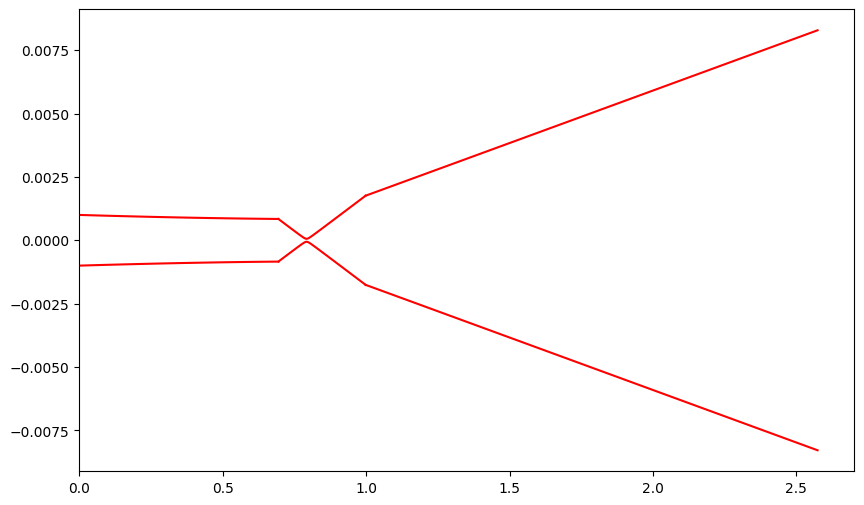

In [26]:
open_setup((0.1,0.4), modes, setups, s0, lam0,r0=r0)

/Users/jonathanvarghese/anaconda3/lib/python3.10/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/Users/jonathanvarghese/anaconda3/lib/python3.10/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/Users/jonathanvarghese/anaconda3/lib/python3.10/site-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


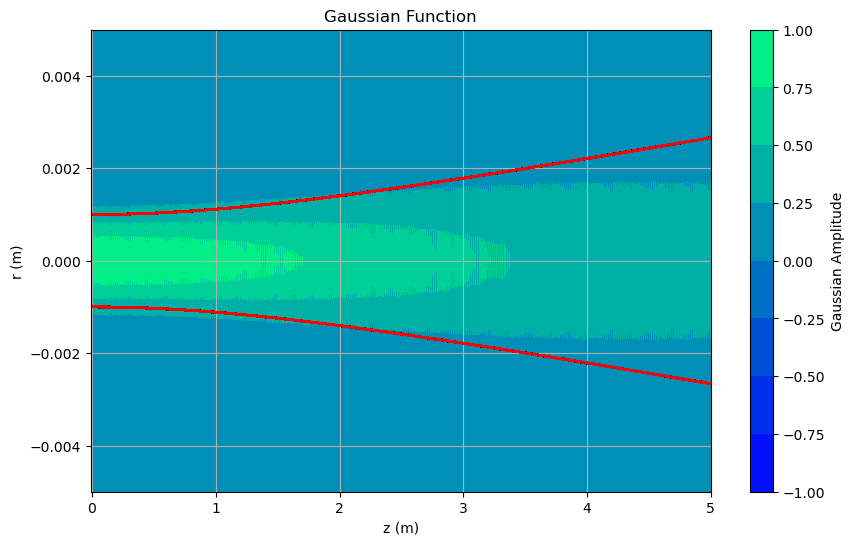

In [476]:
# Define constants
w0 = 1e-5  # Waist radius
lam0 =1550*10**-9  # Wavelength
n = 1.0  # Refractive index

# Define the range for r and z
r_values = np.linspace(-0.005, 0.005, 1000)
z_values = np.linspace(-0.01, 5, 10000)
# Create a meshgrid for r and z
r, z = np.meshgrid(r_values, z_values)


# Calculate the Gaussian values
G, w = Gaussian(r, z, w0, lam0)


# Plot the Gaussian values with color gradient
plt.figure(figsize=(10, 6))
plt.plot(z, w,'-r')
plt.plot(z, -w,'-r')

plt.contourf(z, r, G, cmap='winter')
plt.colorbar(label='Gaussian Amplitude')
plt.xlabel('z (m)')
plt.ylabel('r (m)')
plt.title('Gaussian Function')
plt.grid(True)
plt.show()

In [14]:
lenses=[]
lenses_str = input("Input list of lens  separated by a comma,  (ex: lens1, lens2, lens3 ): ").split(',')
for str in lenses_str:
    lenses.append(float(str))

<class 'float'>


In [48]:
a = 5.252
b = round(a,0)

In [49]:
b

5.0